<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Unit6_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install ucimlrepo

In [42]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [43]:
from ucimlrepo import fetch_ucirepo

# Fetch the heart disease dataset
heart_disease = fetch_ucirepo(id=45)

# Extract features (using the 'name' column) and target variable
feature_names = heart_disease.variables[heart_disease.variables['role'] == 'Feature']['name'].tolist()
target_name = heart_disease.variables[heart_disease.variables['role'] == 'Target']['name'].iloc[0]

# Combine features and target into a single DataFrame
X = heart_disease.data.features
y = heart_disease.data.targets

# Convert the feature data into a pandas DataFrame with the correct column names
heart_df = pd.DataFrame(X, columns=feature_names)

# Add the target column
heart_df[target_name] = y

# Rename columns for readability
heart_df.columns = ['Age', 'Sex', 'Chest Pain', 'RestBP', 'Cholesterol', 'Fasting Blood Sugar',
                    'Resting Electrocardiographic Results', 'MaxHR', 'Angina', 'Oldpeak', 'Slope',
                    'Number of Major Vessels', 'Thalassemia', 'HeartD']

# Save the DataFrame to a CSV file
heart_df.to_csv('heart_disease_dataset.csv', index=False)

# Display the first few rows of the DataFrame to check the result
heart_df


,Age,Sex,Chest Pain,RestBP,Cholesterol,Fasting Blood Sugar,Resting Electrocardiographic Results,MaxHR,Angina,Oldpeak,Slope,Number of Major Vessels,Thalassemia,HeartD
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [44]:
!pip install bambi

In [45]:
import bambi as bmb

# Define the models with triple combinations of predictors
model_rbp_bmb_1 = bmb.Model("RestBP ~ Age + Cholesterol + MaxHR", heart_df, family="gaussian")
model_rbp_bmb_2 = bmb.Model("RestBP ~ Cholesterol + MaxHR + Oldpeak", heart_df, family="gaussian")

# Fit the models and store the posterior samples
idata_rbp_bmb_1 = model_rbp_bmb_1.fit(idata_kwargs={"log_likelihood": True})
idata_rbp_bmb_2 = model_rbp_bmb_2.fit(idata_kwargs={"log_likelihood": True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:03

In [46]:
import arviz as az

# Compare models using LOO (you can also use 'waic' here for WAIC comparison)
cmp_df = az.compare(
    {"Model 1 (Age + Chol + MaxHR)": idata_rbp_bmb_1,
     "Model 2 (Age + Chol + Oldpeak)": idata_rbp_bmb_2},
    ic="loo"  # Use "waic" for WAIC if desired
)

# Show the comparison dataframe
print(cmp_df)

                                rank     elpd_loo     p_loo  elpd_diff  \
Model 1 (Age + Chol + MaxHR)       0 -1289.337539  5.517742    0.00000   
Model 2 (Age + Chol + Oldpeak)     1 -1295.902999  5.643788    6.56546   

                                  weight         se       dse  warning scale  
Model 1 (Age + Chol + MaxHR)    0.722363  14.991376  0.000000    False   log  
Model 2 (Age + Chol + Oldpeak)  0.277637  14.296174  5.956085    False   log  


In [27]:
with pm.Model() as model_mhd:

    # Priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)  # Intercept
    β0 = pm.Normal("β0", mu=0, sigma=10)  # Coefficient for Age
    β1 = pm.Normal("β1", mu=0, sigma=10)  # Coefficient for Max Heart Rate
    β2 = pm.Normal("β2", mu=0, sigma=10)  # Coefficient for Cholesterol

    # Linear part of the model (predictor equation)
    μ = α + β0 * heart_df.Age + β1 * heart_df.MaxHR + β2 * heart_df.Cholesterol

    # Prior for the standard deviation (dispersion)
    σ = pm.HalfNormal("σ", sigma=10)

    # Likelihood (Normal distribution for resting blood pressure)
    y_pred = pm.Normal("y", mu=μ, sigma=σ, observed=heart_df.RestBP)

    # Sample from the posterior
    idata_mhd = pm.sample(idata_kwargs={"log_likelihood": True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:09

In [ ]:
pm.sample_posterior_predictive(idata_mhd, model = model_mhd, extend_inferencedata=True)

In [ ]:
with pm.Model() as model_nbh:

    # Priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)  # Intercept
    β0 = pm.Normal("β0", mu=0, sigma=10)  # Coefficient for Age
    β1 = pm.Normal("β1", mu=0, sigma=10)  # Coefficient for Max Heart Rate
    β2 = pm.Normal("β2", mu=0, sigma=10)  # Coefficient for Cholesterol

    # Linear part of the model (predictor equation)
    μ = pm.math.exp(α + β0 * heart_df.Age + β1 * heart_df.MaxHR + β2 * heart_df.RestBP)

    # Prior for the standard deviation (dispersion)
    σ = pm.HalfNormal("σ", sigma=10)

    # Likelihood (Negative Binomial distribution for cholesterol)
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=heart_df.Cholesterol)

    # Sample from the posterior
    idata_nbh = pm.sample(idata_kwargs={"log_likelihood": True})

In [30]:
pm.sample_posterior_predictive(idata_nbh, model = model_nbh, extend_inferencedata=True)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [47]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"normal":idata_mhd,"negative binomial":idata_nbh} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
normal,0,-1314.497341,4.995329,0.00000,0.993474,14.374861,0.000000,False,log
negative binomial,1,-1608.794001,5.482864,294.29666,0.006526,15.694648,19.021689,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

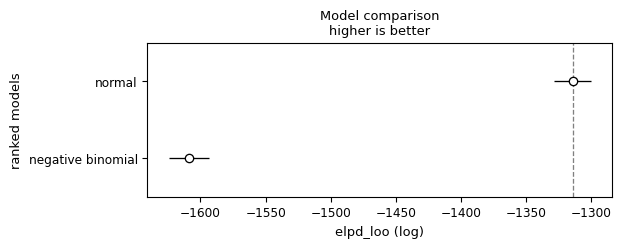

In [48]:
az.plot_compare(cmp_df)

In [33]:
!pip install bambi

In [34]:
import bambi as bmb

In [62]:
model_heart_bmb = bmb.Model("RestBP ~ MaxHR + Cholesterol", heart_df, family="gaussian")
idata_heart_bmb = model_heart_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [63]:
model_heart_bmb

       Formula: RestBP ~ MaxHR + Cholesterol
        Family: gaussian
          Link: mu = identity
  Observations: 303
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 131.6898, sigma: 358.728)
            MaxHR ~ Normal(mu: 0.0, sigma: 1.9235)
            Cholesterol ~ Normal(mu: 0.0, sigma: 0.8498)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 17.5707)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 52 Axes>,
 array([[<Axes: title={'center': 'Cholesterol = 126'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 134'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 143'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 152'}, xlabel='MaxHR', ylabel='RestBP'>],
        [<Axes: title={'center': 'Cholesterol = 161'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 170'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 179'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 188'}, xlabel='MaxHR', ylabel='RestBP'>],
        [<Axes: title={'center': 'Cholesterol = 197'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 206'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 215'}, xlabel='MaxHR', 

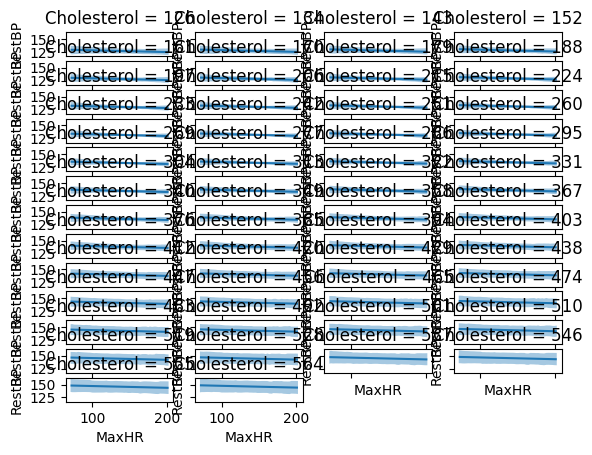

In [66]:
bmb.interpret.plot_predictions(model_heart_bmb, idata_heart_bmb, ["MaxHR", "Cholesterol"],
                               subplot_kwargs={"group":None, "panel":"Cholesterol"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 52 Axes>,
 array([[<Axes: title={'center': 'Cholesterol = 126'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 134'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 143'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 152'}, xlabel='MaxHR', ylabel='RestBP'>],
        [<Axes: title={'center': 'Cholesterol = 161'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 170'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 179'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 188'}, xlabel='MaxHR', ylabel='RestBP'>],
        [<Axes: title={'center': 'Cholesterol = 197'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 206'}, xlabel='MaxHR', ylabel='RestBP'>,
         <Axes: title={'center': 'Cholesterol = 215'}, xlabel='MaxHR', 

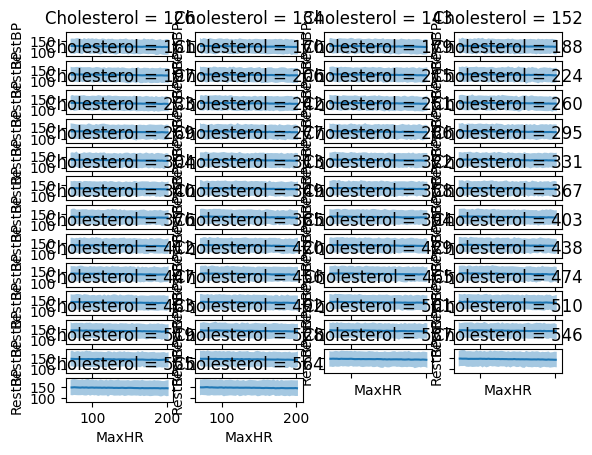

In [69]:
bmb.interpret.plot_predictions(model_heart_bmb, idata_heart_bmb, ["MaxHR", "Cholesterol"],
                               subplot_kwargs={"group":None, "panel":"Cholesterol"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True},pps=True)

In [76]:
model_heart_df = bmb.Model("`RestBP` ~ `MaxHR` + `Age`", data=heart_df)
#fit the model
idata_heart = model_heart_df.fit(idata_kwargs={'log_likelihood': True})


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='MaxHR', ylabel='RestBP'>], dtype=object))

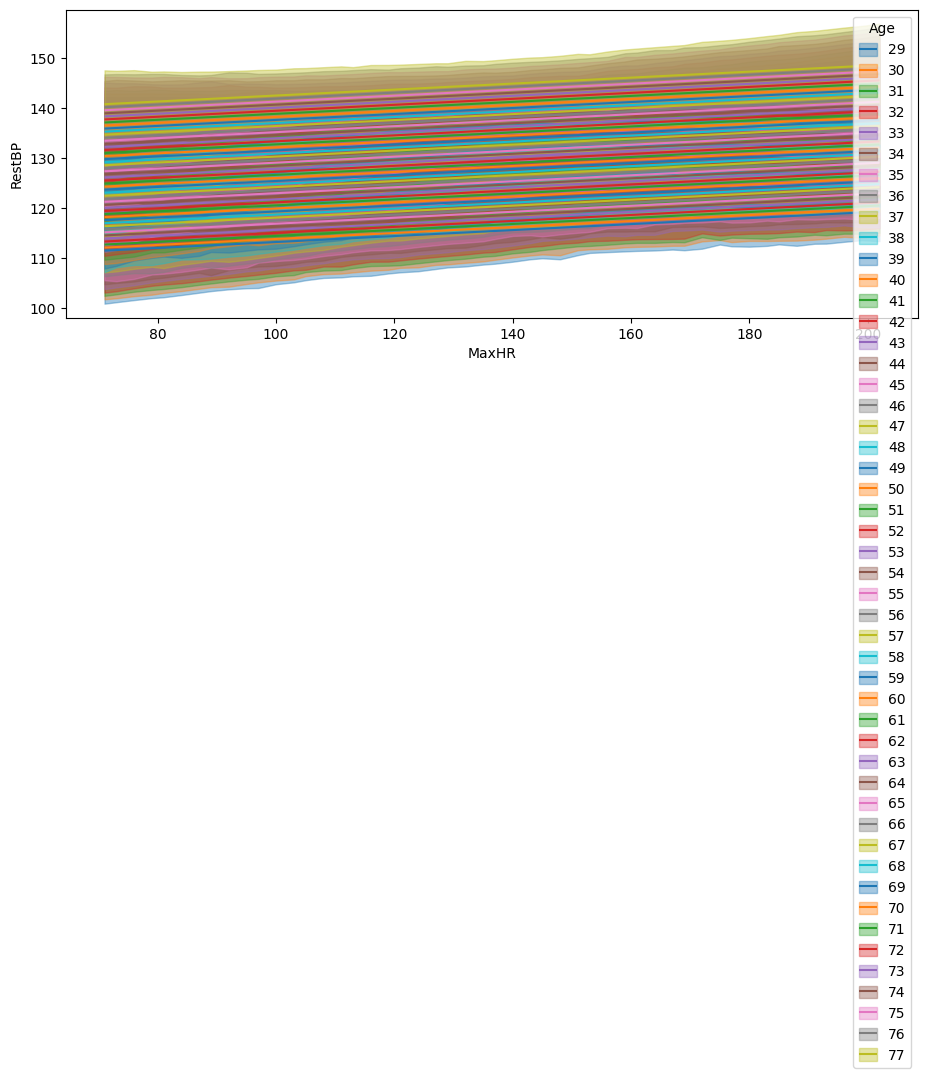

In [77]:
bmb.interpret.plot_predictions(model_heart_df,
                               idata_heart,
                                ["MaxHR", "Age"], fig_kwargs={"figsize":(11, 4)})